In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,4].values # Cd values

In [25]:
y = target_c3.reshape((-1,1))

In [26]:
y.shape

(144, 1)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 113)

In [29]:
y_train.shape

(100, 1)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 1)                 17    

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=500, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [36]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 1s 5ms/step - loss: 1.1861 - rmse: 1.0891 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.4337 - rmse: 0.6585 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.3262 - rmse: 0.5711 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.1828 - rmse: 0.4276 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1884 - rmse: 0.4341 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.1381 - rmse: 0.3716 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0996 - rmse: 0.3157 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0798 - rmse: 0.2825 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0626 - rmse: 0.2503 - lr: 0.0010
Epoch 10/5000
5/5 [==================

Epoch 77/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0129 - rmse: 0.1137 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0090 - rmse: 0.0949 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0112 - rmse: 0.1060 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0093 - rmse: 0.0962 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0088 - rmse: 0.0936 - lr: 0.0010
Epoch 83/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0087 - rmse: 0.0931 - lr: 0.0010
Epoch 84/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0991 - lr: 0.0010
Epoch 85/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1076 - lr: 0.0010
Epoch 86/5000
5/5 [=========

5/5 [==============================] - 0s 5ms/step - loss: 9.3891e-04 - rmse: 0.0306 - lr: 0.0010
Epoch 152/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.1267e-04 - rmse: 0.0248 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1285e-04 - rmse: 0.0226 - lr: 0.0010
Epoch 154/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0338 - lr: 0.0010
Epoch 155/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.9441e-04 - rmse: 0.0282 - lr: 0.0010
Epoch 156/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0325 - lr: 0.0010
Epoch 157/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.9070e-04 - rmse: 0.0243 - lr: 0.0010
Epoch 158/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.8704e-04 - rmse: 0.0197 - lr: 0.0010
Epoch 159/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.2635e-04 - rmse: 0.0181 - lr: 0.0010
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 1.4590e-04 - rmse: 0.0121 - lr: 0.0010
Epoch 224/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4331e-04 - rmse: 0.0120 - lr: 0.0010
Epoch 225/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.4308e-05 - rmse: 0.0092 - lr: 0.0010
Epoch 226/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.3873e-05 - rmse: 0.0086 - lr: 0.0010
Epoch 227/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.5480e-05 - rmse: 0.0081 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1917e-04 - rmse: 0.0109 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7716e-04 - rmse: 0.0133 - lr: 0.0010
Epoch 230/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3445e-04 - rmse: 0.0116 - lr: 0.0010
Epoch 231/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1301e-04 - rmse: 0.0106 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 2.6562e-04 - rmse: 0.0163 - lr: 0.0010
Epoch 297/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8493e-04 - rmse: 0.0196 - lr: 0.0010
Epoch 298/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.6104e-04 - rmse: 0.0257 - lr: 0.0010
Epoch 299/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8594e-04 - rmse: 0.0196 - lr: 0.0010
Epoch 300/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.1010e-04 - rmse: 0.0145 - lr: 0.0010
Epoch 301/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.5025e-04 - rmse: 0.0187 - lr: 0.0010
Epoch 302/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.7893e-04 - rmse: 0.0195 - lr: 0.0010
Epoch 303/5000
5/5 [==============================] - 0s 6ms/step - loss: 3.4644e-04 - rmse: 0.0186 - lr: 0.0010
Epoch 304/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1027e-04 - rmse: 0.0226 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 2.2366e-05 - rmse: 0.0047 - lr: 0.0010
Epoch 369/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7225e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 370/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0662e-05 - rmse: 0.0045 - lr: 0.0010
Epoch 371/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.5715e-05 - rmse: 0.0060 - lr: 0.0010
Epoch 372/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3993e-04 - rmse: 0.0118 - lr: 0.0010
Epoch 373/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0250e-04 - rmse: 0.0174 - lr: 0.0010
Epoch 374/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.8585e-04 - rmse: 0.0136 - lr: 0.0010
Epoch 375/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.5472e-04 - rmse: 0.0124 - lr: 0.0010
Epoch 376/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3545e-04 - rmse: 0.0116 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 0.0078 - rmse: 0.0885 - lr: 0.0010
Epoch 442/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0087 - rmse: 0.0932 - lr: 0.0010
Epoch 443/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0074 - rmse: 0.0862 - lr: 0.0010
Epoch 444/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - rmse: 0.0749 - lr: 0.0010
Epoch 445/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0611 - lr: 0.0010
Epoch 446/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0465 - lr: 0.0010
Epoch 447/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0361 - lr: 0.0010
Epoch 448/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.0856e-04 - rmse: 0.0284 - lr: 0.0010
Epoch 449/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.4079e-04 - rmse: 0.0210 - lr: 0.0010
Epoch 450/5000
5/5 [======

Epoch 514/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1147e-05 - rmse: 0.0072 - lr: 0.0010
Epoch 515/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.4284e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 516/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.2368e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 517/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.6056e-05 - rmse: 0.0093 - lr: 0.0010
Epoch 518/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2725e-04 - rmse: 0.0113 - lr: 0.0010
Epoch 519/5000
5/5 [==============================] - 0s 6ms/step - loss: 8.0587e-05 - rmse: 0.0090 - lr: 0.0010
Epoch 520/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6653e-04 - rmse: 0.0129 - lr: 0.0010
Epoch 521/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1365e-04 - rmse: 0.0107 - lr: 0.0010
Epoch 522/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.7546e-05 - rmse: 0.0

5/5 [==============================] - 0s 5ms/step - loss: 4.8383e-04 - rmse: 0.0220 - lr: 0.0010
Epoch 587/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.9203e-04 - rmse: 0.0243 - lr: 0.0010
Epoch 588/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8794e-04 - rmse: 0.0197 - lr: 0.0010
Epoch 589/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.6680e-04 - rmse: 0.0216 - lr: 0.0010
Epoch 590/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.4730e-04 - rmse: 0.0211 - lr: 0.0010
Epoch 591/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0491e-04 - rmse: 0.0175 - lr: 0.0010
Epoch 592/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.3980e-04 - rmse: 0.0155 - lr: 0.0010
Epoch 593/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6983e-04 - rmse: 0.0164 - lr: 0.0010
Epoch 594/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.9825e-04 - rmse: 0.0173 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 4.3573e-04 - rmse: 0.0209 - lr: 0.0010
Epoch 659/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.5133e-04 - rmse: 0.0159 - lr: 0.0010
Epoch 660/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7359e-04 - rmse: 0.0132 - lr: 0.0010
Epoch 661/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3861e-04 - rmse: 0.0118 - lr: 0.0010
Epoch 662/5000
5/5 [==============================] - 0s 6ms/step - loss: 1.5921e-04 - rmse: 0.0126 - lr: 0.0010
Epoch 663/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.5930e-04 - rmse: 0.0161 - lr: 0.0010
Epoch 664/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0488e-04 - rmse: 0.0175 - lr: 0.0010
Epoch 665/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8401e-04 - rmse: 0.0196 - lr: 0.0010
Epoch 666/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.6520e-04 - rmse: 0.0258 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 3.9014e-04 - rmse: 0.0198 - lr: 0.0010
Epoch 732/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.3616e-04 - rmse: 0.0271 - lr: 0.0010
Epoch 733/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0353 - lr: 0.0010
Epoch 734/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0322 - lr: 0.0010
Epoch 735/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.7808e-04 - rmse: 0.0296 - lr: 0.0010
Epoch 736/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.8478e-04 - rmse: 0.0242 - lr: 0.0010
Epoch 737/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0964e-04 - rmse: 0.0176 - lr: 0.0010
Epoch 738/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.9815e-04 - rmse: 0.0200 - lr: 0.0010
Epoch 739/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3326e-04 - rmse: 0.0115 - lr: 0.0010
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 4.6925e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 804/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.3597e-05 - rmse: 0.0066 - lr: 0.0010
Epoch 805/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.6332e-05 - rmse: 0.0081 - lr: 0.0010
Epoch 806/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.1385e-05 - rmse: 0.0078 - lr: 0.0010
Epoch 807/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.2471e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 808/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.2815e-05 - rmse: 0.0065 - lr: 0.0010
Epoch 809/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.0426e-05 - rmse: 0.0071 - lr: 0.0010
Epoch 810/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.7636e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 811/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0018e-04 - rmse: 0.0100 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 2.4951e-05 - rmse: 0.0050 - lr: 0.0010
Epoch 877/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6207e-05 - rmse: 0.0051 - lr: 0.0010
Epoch 878/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.9217e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 879/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.2314e-05 - rmse: 0.0047 - lr: 0.0010
Epoch 880/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.4080e-05 - rmse: 0.0049 - lr: 0.0010
Epoch 881/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0445e-05 - rmse: 0.0045 - lr: 0.0010
Epoch 882/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5182e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 883/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6922e-05 - rmse: 0.0041 - lr: 0.0010
Epoch 884/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1837e-05 - rmse: 0.0034 - lr: 0.001

5/5 [==============================] - 0s 6ms/step - loss: 1.4180e-04 - rmse: 0.0119 - lr: 0.0010
Epoch 949/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.5212e-05 - rmse: 0.0087 - lr: 0.0010
Epoch 950/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1665e-04 - rmse: 0.0108 - lr: 0.0010
Epoch 951/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.7323e-05 - rmse: 0.0088 - lr: 0.0010
Epoch 952/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.8243e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 953/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.9108e-05 - rmse: 0.0077 - lr: 0.0010
Epoch 954/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.3799e-05 - rmse: 0.0066 - lr: 0.0010
Epoch 955/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.9710e-05 - rmse: 0.0055 - lr: 0.0010
Epoch 956/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8514e-05 - rmse: 0.0062 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 9.6519e-04 - rmse: 0.0311 - lr: 0.0010
Epoch 1021/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.4463e-04 - rmse: 0.0254 - lr: 0.0010
Epoch 1022/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0332 - lr: 0.0010
Epoch 1023/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0466 - lr: 0.0010
Epoch 1024/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0318 - lr: 0.0010
Epoch 1025/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0045 - rmse: 0.0669 - lr: 0.0010
Epoch 1026/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0622 - lr: 0.0010
Epoch 1027/5000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0550 - lr: 0.0010
Epoch 1028/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0195 - rmse: 0.1397 - lr: 0.0010
Epoch 1029/5000
5/

5/5 [==============================] - 0s 5ms/step - loss: 1.6199e-05 - rmse: 0.0040 - lr: 0.0010
Epoch 1093/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6093e-05 - rmse: 0.0040 - lr: 0.0010
Epoch 1094/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4732e-05 - rmse: 0.0038 - lr: 0.0010
Epoch 1095/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5608e-05 - rmse: 0.0040 - lr: 0.0010
Epoch 1096/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6822e-05 - rmse: 0.0041 - lr: 0.0010
Epoch 1097/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3329e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 1098/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2224e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 1099/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3686e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 1100/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5609e-05 - rmse: 0.0040 - l

5/5 [==============================] - 0s 5ms/step - loss: 7.8496e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 1165/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.0331e-06 - rmse: 0.0025 - lr: 0.0010
Epoch 1166/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.4982e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 1167/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.9268e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 1168/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.5240e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 1169/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3347e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 1170/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7264e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 1171/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.7449e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 1172/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.4965e-06 - rmse: 0.0029 - l

5/5 [==============================] - 0s 5ms/step - loss: 2.4613e-04 - rmse: 0.0157 - lr: 0.0010
Epoch 1237/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0219e-04 - rmse: 0.0142 - lr: 0.0010
Epoch 1238/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.2494e-04 - rmse: 0.0229 - lr: 0.0010
Epoch 1239/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1667e-04 - rmse: 0.0227 - lr: 0.0010
Epoch 1240/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.0963e-04 - rmse: 0.0302 - lr: 0.0010
Epoch 1241/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.2772e-04 - rmse: 0.0270 - lr: 0.0010
Epoch 1242/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.8060e-04 - rmse: 0.0313 - lr: 0.0010
Epoch 1243/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0434 - lr: 0.0010
Epoch 1244/5000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0599 - lr: 0.001

5/5 [==============================] - 0s 5ms/step - loss: 5.8401e-05 - rmse: 0.0076 - lr: 0.0010
Epoch 1310/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.4433e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 1311/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.6811e-05 - rmse: 0.0068 - lr: 0.0010
Epoch 1312/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.1698e-05 - rmse: 0.0065 - lr: 0.0010
Epoch 1313/5000
5/5 [==============================] - 0s 6ms/step - loss: 4.5015e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 1314/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.9550e-05 - rmse: 0.0070 - lr: 0.0010
Epoch 1315/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.8192e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 1316/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.5084e-05 - rmse: 0.0059 - lr: 0.0010
Epoch 1317/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.7962e-05 - rmse: 0.0062 - l

5/5 [==============================] - 0s 5ms/step - loss: 3.9897e-05 - rmse: 0.0063 - lr: 0.0010
Epoch 1382/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.0348e-05 - rmse: 0.0064 - lr: 0.0010
Epoch 1383/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.3306e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 1384/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.9839e-05 - rmse: 0.0071 - lr: 0.0010
Epoch 1385/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1705e-05 - rmse: 0.0072 - lr: 0.0010
Epoch 1386/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.8926e-05 - rmse: 0.0062 - lr: 0.0010
Epoch 1387/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6795e-05 - rmse: 0.0052 - lr: 0.0010
Epoch 1388/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.3384e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 1389/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6030e-05 - rmse: 0.0051 - l

5/5 [==============================] - 0s 5ms/step - loss: 1.0268e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 1454/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0655e-05 - rmse: 0.0033 - lr: 0.0010
Epoch 1455/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.1413e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 1456/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.5892e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 1457/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0180e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 1458/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.3254e-06 - rmse: 0.0025 - lr: 0.0010
Epoch 1459/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.3801e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 1460/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0245e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 1461/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.5009e-06 - rmse: 0.0029 - l

5/5 [==============================] - 0s 5ms/step - loss: 2.3582e-05 - rmse: 0.0049 - lr: 0.0010
Epoch 1526/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.2966e-05 - rmse: 0.0048 - lr: 0.0010
Epoch 1527/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6090e-05 - rmse: 0.0051 - lr: 0.0010
Epoch 1528/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.9017e-05 - rmse: 0.0044 - lr: 0.0010
Epoch 1529/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3524e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 1530/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.1301e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 1531/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.1304e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 1532/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.7515e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 1533/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.3219e-06 - rmse: 0.0025 - l

5/5 [==============================] - 0s 4ms/step - loss: 4.7702e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 1598/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1173e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 1599/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.7348e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 1600/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.7137e-05 - rmse: 0.0052 - lr: 0.0010
Epoch 1601/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8742e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 1602/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8864e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 1603/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4957e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 1604/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.5514e-05 - rmse: 0.0051 - lr: 0.0010
Epoch 1605/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0784e-05 - rmse: 0.0046 - l

5/5 [==============================] - 0s 5ms/step - loss: 4.3365e-04 - rmse: 0.0208 - lr: 0.0010
Epoch 1670/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.1841e-04 - rmse: 0.0205 - lr: 0.0010
Epoch 1671/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.1390e-04 - rmse: 0.0177 - lr: 0.0010
Epoch 1672/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.1968e-04 - rmse: 0.0205 - lr: 0.0010
Epoch 1673/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.7923e-04 - rmse: 0.0195 - lr: 0.0010
Epoch 1674/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.0613e-04 - rmse: 0.0175 - lr: 0.0010
Epoch 1675/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.6684e-04 - rmse: 0.0129 - lr: 0.0010
Epoch 1676/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.3891e-04 - rmse: 0.0118 - lr: 0.0010
Epoch 1677/5000
1/5 [=====>........................] - ETA: 0s - loss: 1.2322e-04 - rmse: 0.0111
Epoch 1

5/5 [==============================] - 0s 4ms/step - loss: 8.7257e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 1738/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.5379e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 1739/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.4751e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 1740/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.5340e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 1741/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0517e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 1742/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.9552e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 1743/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.2627e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1744/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1379e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 1745/5000
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 2.3532e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 1807/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.4616e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1808/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.4418e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1809/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.5597e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1810/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.9674e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 1811/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6936e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1812/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.2385e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 1813/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6179e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1814/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 2.3920e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 1876/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4722e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1877/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.3732e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1878/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8780e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1879/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.6920e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1880/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.2112e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1881/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4544e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1882/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5189e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1883/5000
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 1.1221e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1945/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4312e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1946/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.9083e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1947/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.0705e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1948/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.6297e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 1949/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.9092e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 1950/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3461e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 1951/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.6492e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 1952/5000
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 2.1090e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 2014/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.6748e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 2015/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.8739e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 2016/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.9630e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 2017/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.0865e-06 - rmse: 0.0027 - lr: 5.0000e-04
Epoch 2018/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.7232e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 2019/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1657e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 2020/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4066e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 2021/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 3.0260e-05 - rmse: 0.0055 - lr: 5.0000e-04
Epoch 2083/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.3997e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 2084/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.1852e-05 - rmse: 0.0056 - lr: 5.0000e-04
Epoch 2085/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6824e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 2086/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1722e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 2087/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2651e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 2088/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0770e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 2089/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7736e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 2090/5000
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 6.9916e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 2152/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.6266e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 2153/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.5069e-06 - rmse: 0.0027 - lr: 5.0000e-04
Epoch 2154/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.6998e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 2155/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.7296e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 2156/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.4537e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 2157/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.4097e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 2158/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0139e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 2159/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 1.5311e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2221/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6356e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 2222/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8598e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2223/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0225e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 2224/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4297e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2225/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.8725e-07 - rmse: 8.2901e-04 - lr: 5.0000e-04
Epoch 2226/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0722e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 2227/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.2319e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2228/5000
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 4ms/step - loss: 1.2744e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 2290/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.8630e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 2291/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.5762e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 2292/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0554e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2293/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.5966e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 2294/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.9068e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 2295/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.2183e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 2296/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.6559e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 2297/5000
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 6.8576e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 2359/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.1339e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 2360/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.0487e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 2361/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.6792e-06 - rmse: 0.0031 - lr: 5.0000e-04
Epoch 2362/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0702e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 2363/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.2721e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 2364/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.6833e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 2365/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.9760e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 2366/5000
5/5 [==============================] - 0s 4ms/step - los

Epoch 2428/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.0241e-05 - rmse: 0.0045 - lr: 5.0000e-04
Epoch 2429/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.2402e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 2430/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.7694e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 2431/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1262e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 2432/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.3514e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 2433/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.7103e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 2434/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5006e-05 - rmse: 0.0039 - lr: 5.0000e-04
Epoch 2435/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0270e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 2436/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 3.3385e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 2498/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.5071e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 2499/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.3715e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 2500/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6713e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2501/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.3174e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 2502/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.3159e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 2503/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.5463e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 2504/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.3043e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 2505/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 1.6557e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2567/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.9885e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2568/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4001e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2569/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0955e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 2570/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.3435e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2571/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1927e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2572/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1247e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2573/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5969e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2574/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 1.4276e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2636/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.8163e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2637/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6883e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2638/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6701e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2639/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.5141e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2640/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1776e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2641/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.3830e-07 - rmse: 9.6866e-04 - lr: 5.0000e-04
Epoch 2642/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.5745e-07 - rmse: 8.7031e-04 - lr: 5.0000e-04
Epoch 2643/5000
5/5 [==============================] - 0s 4ms/st

Epoch 2704/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0967e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 2705/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.4186e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 2706/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.7566e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 2707/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.7800e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 2708/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.8143e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 2709/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.4958e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 2710/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1430e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 2711/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.0964e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 2712/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 3.2082e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 2774/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1172e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 2775/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.3979e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 2776/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.0319e-05 - rmse: 0.0055 - lr: 5.0000e-04
Epoch 2777/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.6034e-05 - rmse: 0.0051 - lr: 5.0000e-04
Epoch 2778/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.2756e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 2779/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.6433e-05 - rmse: 0.0051 - lr: 5.0000e-04
Epoch 2780/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.2864e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 2781/5000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 2.6877e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 2843/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.7416e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 2844/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.4838e-05 - rmse: 0.0081 - lr: 5.0000e-04
Epoch 2845/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.0191e-05 - rmse: 0.0071 - lr: 5.0000e-04
Epoch 2846/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.1532e-05 - rmse: 0.0072 - lr: 5.0000e-04
Epoch 2847/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.2508e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 2848/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3857e-05 - rmse: 0.0066 - lr: 5.0000e-04
Epoch 2849/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3258e-05 - rmse: 0.0066 - lr: 5.0000e-04
Epoch 2850/5000
5/5 [==============================] - 0s 4ms/step - los

In [37]:
time = end - start
print("Training time:", time)

Training time: 0:01:14.732214


In [38]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221128MLP_revised\\test"+str(test_rate)+"Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

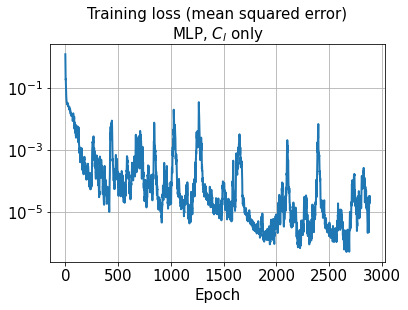

In [39]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

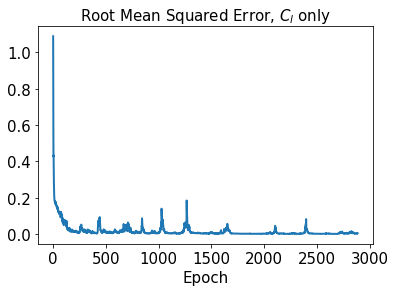

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

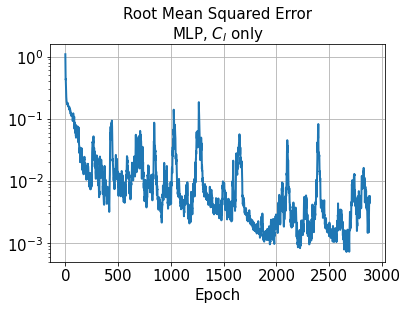

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [42]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 1.0479e-06 - rmse: 0.0010


In [43]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 2.4188e-04 - rmse: 0.0156


In [44]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [45]:
model_directory = "D:\\TrainedModels\\20221128"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221128steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0008208546941439303


In [50]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.013922576543046848


In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

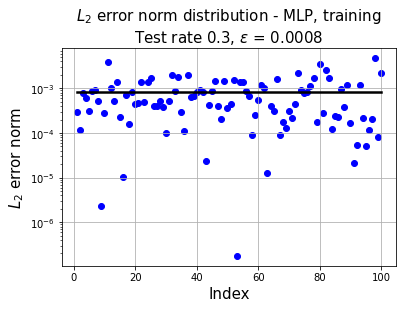

In [53]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

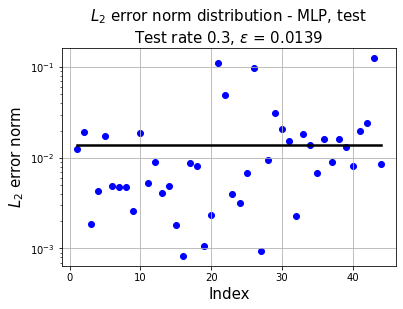

In [54]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [55]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [56]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [57]:
iTrain=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
    
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [58]:
iTrain = np.array(iTrain)
iTest = np.array(iTest)

In [69]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, beta=%d\nCL prediction, L2 error=%.4f'%(h[i], beta[i], l2_error_Cl)
    
    if i==0:
        title_Cl = title_0_Cl
        savename2 =  "ClComparison_NACA0018.jpg"
    else:
        title_Cl = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    '''
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,0]/10, color='b', label='Training set')
    plt.scatter(aTest, iTest[:,0]/10, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
'''
    # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_0_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 14ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0033


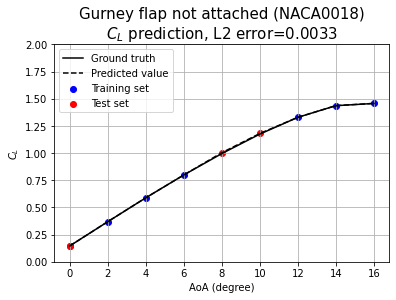

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0080


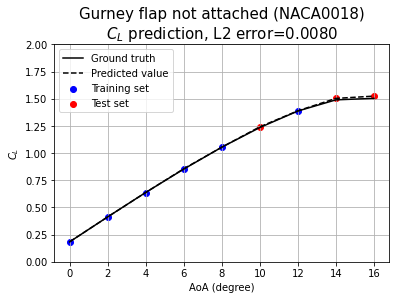

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0067


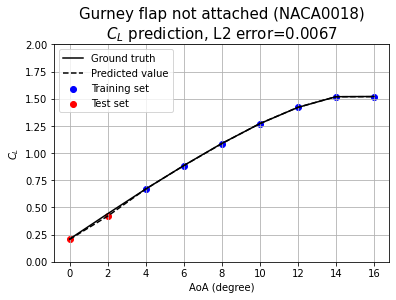

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0107


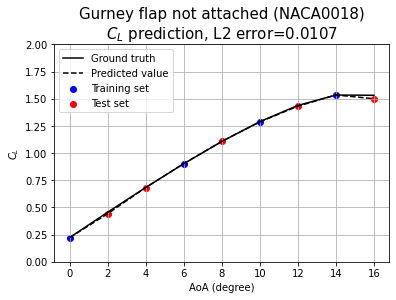

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0131


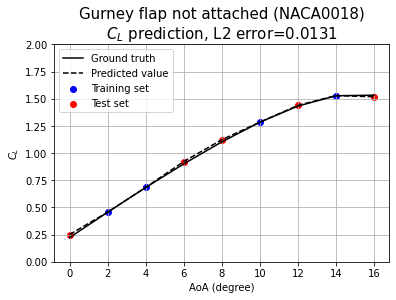

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0129


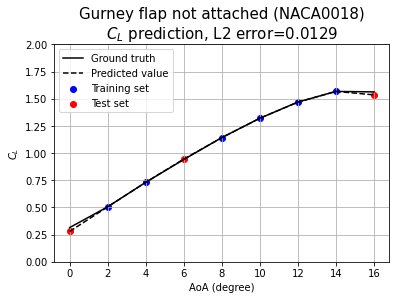

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0030


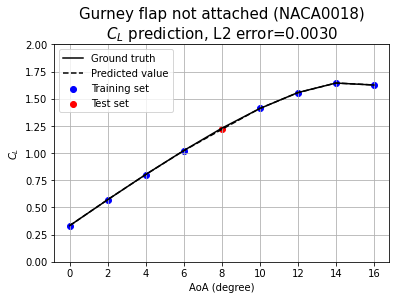

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0023


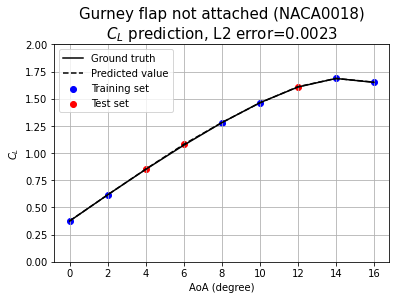

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0034


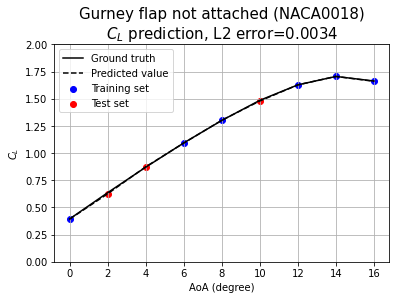

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0011


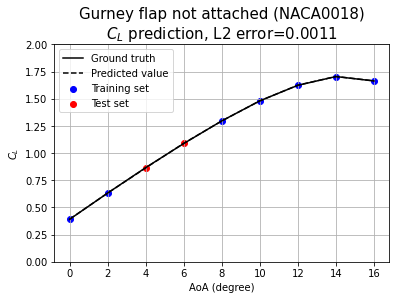

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0127


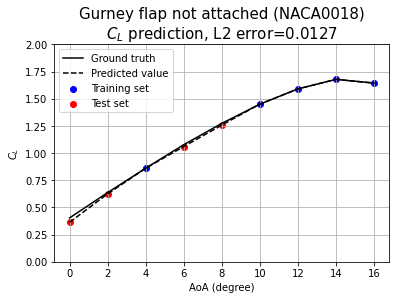

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0045


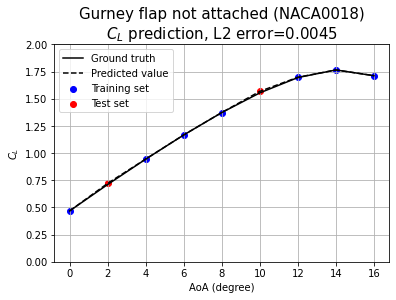

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0031


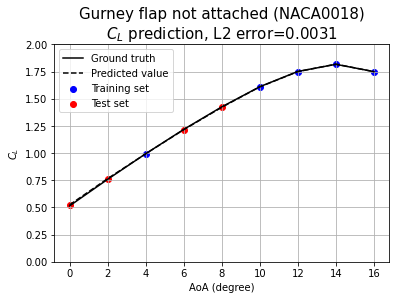

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0018


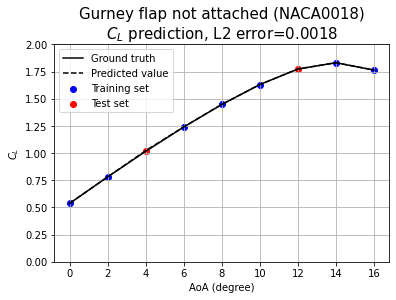

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0078


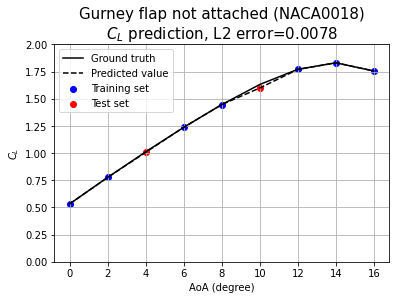

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0021


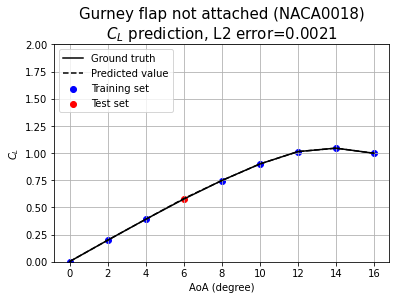

In [72]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]


for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    #l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),:]
    #cd = predicted[n_alpha*i:n_alpha*(i+1),0]/10
    
    CL = y[n_alpha*i:n_alpha*(i+1),:]
    #CD = y[n_alpha*i:n_alpha*(i+1),0]/10
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]*max(alpha)
    aTest = np.array(alpha_test)[:,0]*max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)

In [71]:
aTrain

array([0.   , 0.125, 0.25 , 0.5  , 0.625, 0.75 , 0.875, 1.   ])